In [1]:
# Import necessary libraries
import os
import numpy as np
import wfdb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pywt
from scipy.signal import find_peaks
import neurokit2 as nk


In [2]:


# Configure logging
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [3]:


# Constants
dataset_path = "C:\\Users\\mhame\\pfa_project\\ECG-Heartbeat-Classification\\mit-bih-arrhythmia-database"
record_ids = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114',
              '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205',
              '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223',
              '228', '230', '231', '232', '233', '234']
window_size = 360
overlap = 90  # 50% overlap
fs = 360  # Sampling frequency
label_mapping = {
    'N': 0,  # Normal beat
    'L': 1,  # Left bundle branch block beat
    'R': 2,  # Right bundle branch block beat
    'A': 3,  # Atrial premature beat
    'V': 4   # Premature ventricular contraction
}


In [4]:

# Preprocessing functions
def preprocess_signal(signal, fs=360):
    """Apply bandpass filter and detrend to the signal."""
    from scipy.signal import butter, filtfilt, detrend

    def bandpass_filter(signal, lowcut, highcut, fs, order=4):
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        return filtfilt(b, a, signal)

    filtered_signal = bandpass_filter(signal, lowcut=0.5, highcut=40, fs=fs)
    detrended_signal = detrend(filtered_signal)
    return detrended_signal

# Feature extraction functions
def extract_wavelet_features(ecg_segments):
    features = []
    for segment in ecg_segments:
        # Perform discrete wavelet transform using the Daubechies 4 wavelet
        coeffs = pywt.wavedec(segment, 'db4', level=4)
        # Normalize coefficients for entropy calculation
        normalized_coeffs = [coeff / (np.sum(np.abs(coeff)) + 1e-8) for coeff in coeffs]
        # Calculate the standard deviation of each wavelet coefficient
        std_coeffs = [np.std(coeff) for coeff in coeffs]
        # Calculate the energy of each wavelet coefficient
        energy_coeffs = [np.sum(coeff ** 2) for coeff in coeffs]
        # Calculate the entropy of each wavelet coefficient
        entropy_coeffs = [
            np.sum(-norm_coeff * np.log2(np.clip(norm_coeff, 1e-8, None)))
            for norm_coeff in normalized_coeffs
        ]
        # Concatenate the features
        feature_vector = np.concatenate([std_coeffs, energy_coeffs, entropy_coeffs])
        features.append(feature_vector)
    return np.array(features)

def extract_time_domain_features(segment, fs):
    """Extract time-domain features (mean, std)."""
    return [np.mean(segment), np.std(segment)]

def extract_frequency_features(segment, fs):
    """Extract frequency-domain features (mean FFT magnitude)."""
    fft_magnitude = np.abs(np.fft.fft(segment))
    return [np.mean(fft_magnitude)]

def extract_multilead_features(leads, window_size=180, overlap=90, fs=360):
    step_size = window_size // 2 
    features = []
    for i in range(0, len(leads[0]) - window_size + 1, step_size):
        segment_features = []
        for lead in leads:
            segment = lead[i:i + window_size]
            wavelet_features = extract_wavelet_features([segment])[0]  # Removed 'sampling_rate'
            time_features = extract_time_domain_features(segment, fs)
            freq_features = extract_frequency_features(segment, fs)
            combined_features = np.concatenate([wavelet_features, time_features, freq_features])
            segment_features.extend(combined_features)
        features.append(segment_features)
    return np.array(features)

def align_labels_with_segments(signal, annotations, window_size=180):
    """Align labels with segments based on annotations."""
    step_size = window_size // 2  # 50% overlap
    aligned_labels = []
    label_positions = {sample: label_mapping.get(symbol, -1) for sample, symbol in zip(annotations.sample, annotations.symbol)}
    for i in range(0, len(signal) - window_size + 1, step_size):
        segment_center = i + window_size // 2
        closest_annotation_sample = min(label_positions.keys(), key=lambda x: abs(x - segment_center))
        aligned_labels.append(label_positions[closest_annotation_sample])
    return np.array(aligned_labels)



In [5]:

# Main preprocessing pipeline
all_segments = []
all_labels = []

for record_id in record_ids:
    try:
        # Load the record and annotations
        record = wfdb.rdrecord(f"{dataset_path}/{record_id}")
        annotations = wfdb.rdann(f"{dataset_path}/{record_id}", 'atr')

        # Extract available leads (typically 2 leads: Lead I and Lead II)
        if record.n_sig < 2:
            logger.warning(f"Skipping record {record_id}: Less than 2 leads available.")
            continue

        leads = [preprocess_signal(record.p_signal[:, i], fs) for i in range(record.n_sig)]

        # Extract features
        features = extract_multilead_features(leads, window_size, overlap, fs)

        # Align labels with segments
        aligned_labels = align_labels_with_segments(leads[0], annotations, window_size)

        # Append to global lists
        all_segments.extend(features)
        all_labels.extend(aligned_labels)

    except Exception as e:
        logger.error(f"Error processing record {record_id}: {str(e)}")


In [6]:

# Convert to NumPy arrays
X = np.array(all_segments)
y = np.array(all_labels)


In [7]:
print(f"Number of segments (features): {len(features)}")
print(f"Number of aligned labels: {len(aligned_labels)}")

Number of segments (features): 3610
Number of aligned labels: 3610


In [8]:

print(f"Before filtering: X shape = {X.shape}, y shape = {y.shape}")
valid_indices = y != -1
X = X[valid_indices]
y = y[valid_indices]
print(f"After filtering: X shape = {X.shape}, y shape = {y.shape}")

Before filtering: X shape = (173280, 36), y shape = (173280,)
After filtering: X shape = (155281, 36), y shape = (155281,)


In [9]:

# Check if dataset is empty
if len(X) == 0 or len(y) == 0:
    raise ValueError("No valid segments or labels found. Check the dataset and preprocessing steps.")


In [10]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [11]:


# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    class_weight='balanced',  # Handle class imbalance
    random_state=42
)


In [12]:

# Train the model
rf_classifier.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [13]:

# Make predictions
y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)


In [14]:

# Evaluate the model
print("Random Forest - Training Set Classification Report:")
print(classification_report(y_train, y_train_pred))

print("Random Forest - Test Set Classification Report:")
print(classification_report(y_test, y_test_pred))


Random Forest - Training Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     92808
           1       1.00      1.00      1.00     10360
           2       1.00      1.00      1.00     10322
           3       1.00      1.00      1.00      3020
           4       1.00      1.00      1.00      7714

    accuracy                           1.00    124224
   macro avg       1.00      1.00      1.00    124224
weighted avg       1.00      1.00      1.00    124224

Random Forest - Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     23203
           1       0.96      0.94      0.95      2590
           2       0.96      0.92      0.94      2580
           3       0.88      0.56      0.68       755
           4       0.89      0.72      0.80      1929

    accuracy                           0.95     31057
   macro avg       0.93      0.

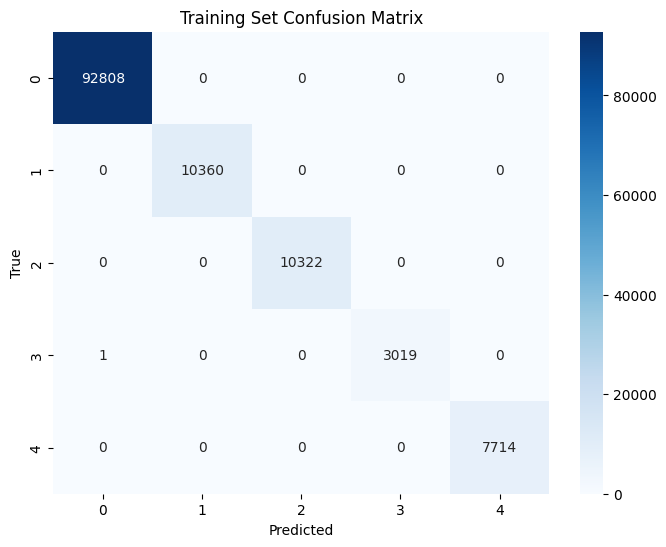

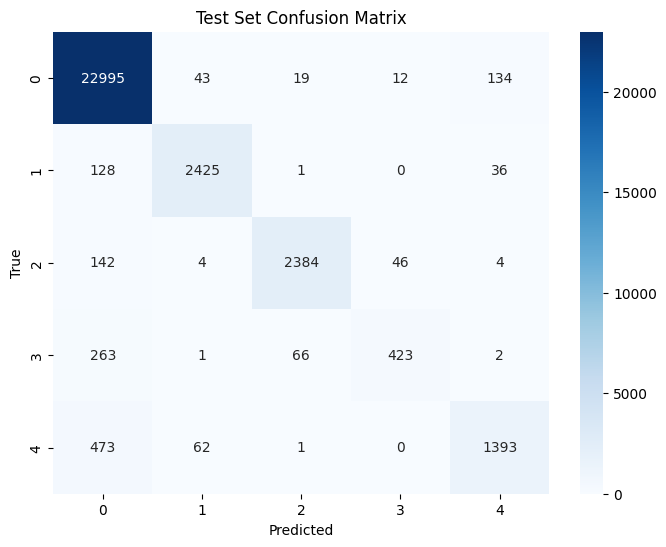

In [15]:

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

plot_confusion_matrix(y_train, y_train_pred, "Training Set Confusion Matrix")
plot_confusion_matrix(y_test, y_test_pred, "Test Set Confusion Matrix")


In [16]:

# ROC-AUC Score
if len(np.unique(y_train)) > 2:  # Multiclass case
    roc_auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test), multi_class='ovr')
else:  # Binary case
    roc_auc = roc_auc_score(y_test, rf_classifier.predict_proba(X_test)[:, 1])
print(f"Test Set ROC-AUC Score: {roc_auc:.4f}")


Test Set ROC-AUC Score: 0.9861


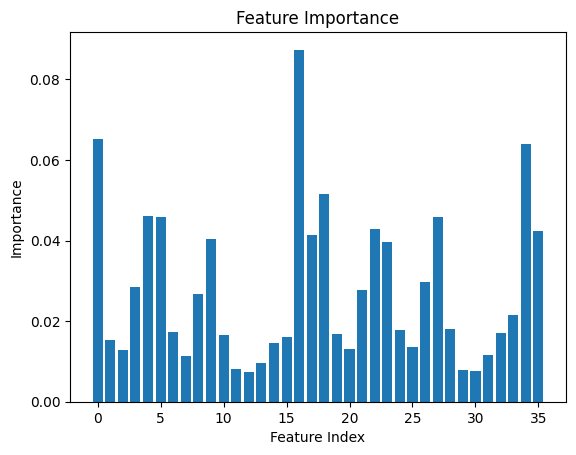

In [17]:

# Plot feature importance
feature_importances = rf_classifier.feature_importances_
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance")
plt.show()


In [18]:

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', None]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(f"Best Parameters: {grid_search.best_params_}")


Best Parameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}


In [19]:

# Save the best model and scaler
joblib.dump(grid_search.best_estimator_, 'random_forest_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']